# Create instances of Data from Gaussian mocks

In [1]:
import time

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import generate_mock, split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func_utils import *

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog_dat = catalog_data.Data.load(data_dir+catalog_name+'.npy')

cellsize = 10
resampler = 'tsc'

# Compute density with weights
catalog = density_split.DensitySplit(catalog_dat)
catalog.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000000.56] [0/1] 06-23 12:58  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000001.29] [0/1] 06-23 12:58  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.


## Mock properties

In [4]:
nmesh = 512
boxsize = catalog.boxsize
boxcenter = catalog.boxcenter
seed = 0
los = 'x'
nbar = catalog.data.size/catalog.boxsize**3

z = catalog.data.redshift

# Abacus summit cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

f = bg.growth_rate(z)
bias = 1.8

pklin = cosmo_abacus.get_fourier().pk_interpolator().to_1d(z)

### Damping at $k_{N}$

In [5]:
kN = np.pi*nmesh/boxsize

In [6]:
kN

1.6084954386379742

In [7]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [8]:
nbar

0.002934922

In [9]:
k=np.logspace(-5, 2, 1000000)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

(0.0, 2.0)

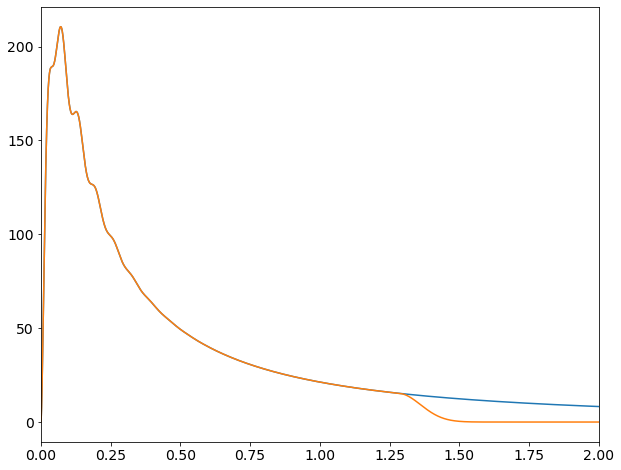

In [10]:
plt.plot(k, k*pklin_array)
plt.plot(k, k*pkdamped(k))
plt.xlim((0, 2))

## Abacus summit cosmology

### Linear power spectrum mock

In [11]:
# unitary_amplitude forces amplitude to 1
mock = EulerianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

mock.set_real_delta_field(bias=bias)

data = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=seed)
data['Weight'] = mock.readout(data['Position'], field='delta', resampler='tsc', compensate=True) + 1.

[000023.35] [0/1] 06-23 12:58  EulerianLinearMock        INFO     White noise generated.


In [ ]:
mock.delta

In [12]:
data['Weight']

array([ 4.26552826 -0.08357486 -1.72410816 ...  1.2096259  -2.88538762
  0.87319657])

In [13]:
# Create Data instance
positions = data['Position'].T % boxsize

# Set rsd
mock.set_rsd(f=f, los=los)
data_rsd = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=seed)
data_rsd['Weight'] = mock.readout(data_rsd['Position'], field='delta', resampler='tsc', compensate=True) + 1.

positions_rsd = data_rsd['Position'].T % boxsize

mock_catalog = catalog_data.Data(positions, z, boxsize, boxcenter, name='mock', weights=data['Weight'])
mock_catalog.set_rsd(positions_rsd=positions_rsd)

mock_catalog.save(output_dir+catalog_name+'_gaussianMock')

In [14]:
data_rsd['Weight']

array([ 5.54788615  0.01193016 -2.12271835 ...  1.52413348 -3.8459552
  1.02022283])

### Damped power spectrum mock

In [15]:
# unitary_amplitude forces amplitude to 1
mock_damped = EulerianLinearMock(pkdamped, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

mock_damped.set_real_delta_field(bias=bias)

data_damped = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=seed)
data_damped['Weight'] = mock_damped.readout(data['Position'], field='delta', resampler='tsc', compensate=True) + 1.

[000060.11] [0/1] 06-17 11:39  EulerianLinearMock        INFO     White noise generated.


In [16]:
# Create Data instance
positions_damped = data_damped['Position'].T % boxsize

# Set rsd
mock_damped.set_rsd(f=f, los=los)
data_damped_rsd = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=seed)
data_damped_rsd['Weight'] = mock_damped.readout(data_damped_rsd['Position'], field='delta', resampler='tsc', compensate=True) + 1.

positions_damped_rsd = data_damped_rsd['Position'].T % boxsize

mock_catalog_damped = catalog_data.Data(positions_damped, z, boxsize, boxcenter, name='mock', weights=data_damped['Weight'])
mock_catalog_damped.set_rsd(positions_rsd=positions_damped_rsd)

mock_catalog_damped.save(output_dir+catalog_name+'_gaussianMock_damped')

In [17]:
np.mean(data_damped['Weight']**2)/nbar

array(2023.7669845743324)

## Compute density

In [18]:
cellsize = 10
resampler = 'tsc'

# Compute density
mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

mock_density_damped = density_split.DensitySplit(mock_catalog_damped )
mock_density_damped .compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000299.11] [0/1] 06-17 11:43  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000300.03] [0/1] 06-17 11:43  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.
[000301.07] [0/1] 06-17 11:43  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000302.00] [0/1] 06-17 11:43  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.


### Plot density distribution

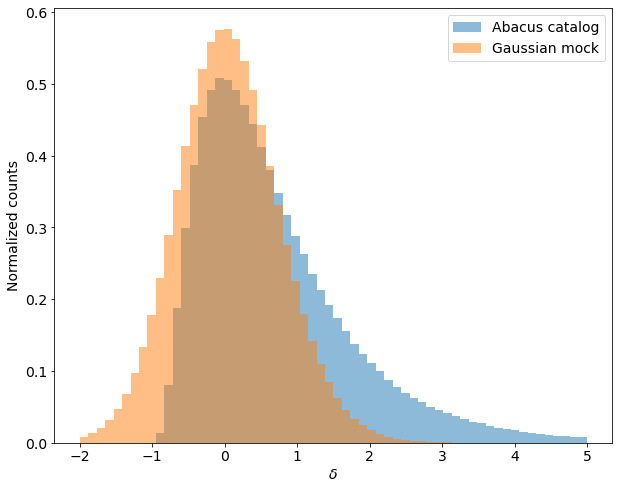

In [17]:
plt.hist(catalog.data_densities, range=(-2, 5), bins=60, density=True, alpha=0.5, label='Abacus catalog')
plt.hist(mock_density.data_densities, range=(-2, 5), bins=60, density=True, alpha=0.5, label='Gaussian mock')
#plt.hist(np.array(catalog.density_mesh).flatten(), range=(-2, 5), bins=60, density=True, alpha=0.5, label='Abacus catalog')
#plt.hist(np.array(mock_density.density_mesh).flatten(), range=(-2, 5), bins=60, density=True, alpha=0.5, label='Gaussian mock')
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.legend()
plt.show()

## Compute 2PCF

In [18]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))
los = 'x'

In [19]:
edges

(array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
         66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
         99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
        132., 135., 138., 141., 144., 147., 150.]),
 array([-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91, -0.9 , -0.89, -0.88, -0.87, -0.86, -0.85, -0.84, -0.83,
        -0.82, -0.81, -0.8 , -0.79, -0.78, -0.77, -0.76, -0.75, -0.74,
        -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.67, -0.66, -0.65,
        -0.64, -0.63, -0.62, -0.61, -0.6 , -0.59, -0.58, -0.57, -0.56,
        -0.55, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47,
        -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38,
        -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
        -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
        -0.19

In [20]:
result = TwoPointCorrelationFunction('smu', edges,
                                     data_positions1=mock_catalog.positions, data_weights1=mock_catalog.weights,
                                     boxsize=mock_catalog.boxsize,
                                     engine='corrfunc', nthreads=128,
                                     los = los)

[000296.97] [0/1] 06-14 18:20  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000296.97] [0/1] 06-14 18:20  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.


Received signal = `Interrupt' (signo = 2). Aborting 


RuntimeError: RuntimeError occurred

## Compare mock 2PCF with data

In [20]:
ells = [0]
nells = len(ells)

In [22]:
abacus_results = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z1.175_2PCF.npy')

[000332.35] [0/1] 06-14 18:21  TwoPointEstimator         INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_2PCF.npy.


In [23]:
s, abacus_xiell = abacus_results.get_corr(ells=ells, return_sep=True)
mocks_xiell = result.get_corr(ells=ells, return_sep=False)

NameError: name 'result' is not defined

NameError: name 'mocks_xiell' is not defined

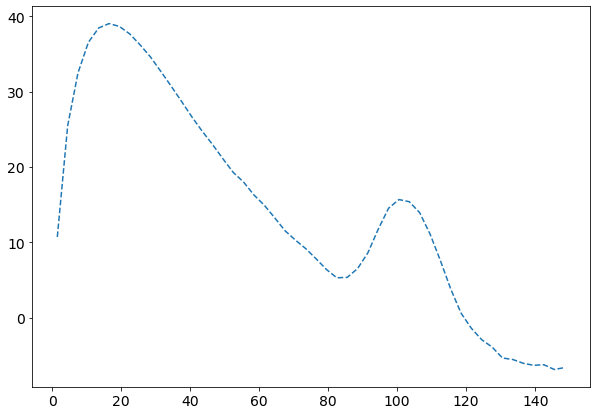

In [24]:
plt.rcParams["figure.figsize"] = (10, 7)

for ill, ell in enumerate(ells):
    plt.plot(s, s**2 * abacus_xiell[ill], linestyle = '--', color='C'+str(ill))
    plt.plot(s, s**2 * mocks_xiell[ill])
    # for legend
    plt.plot([],[], linestyle='-', color='C'+str(ill), label='$\ell = {:d}$'.format(ell))
    plt.grid(True)

plt.plot([],[], linestyle='--', color='black', label='Abacus (2 Gpc)')
plt.plot([],[], linestyle='-', color='black', label='Gaussian mock')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.legend()
plt.show()

In [21]:
from pypower import CatalogFFTPower

result = CatalogFFTPower(data_positions1=data['Position'], data_weights1=data['Weight'], ells=ells, edges={'step': 0.01},
                         boxsize=boxsize, boxcenter=0., nmesh=nmesh * 3 // 2, resampler='tsc', interlacing=2, los='x',
                         position_type='pos', mpicomm=data.mpicomm)

result_damped = CatalogFFTPower(data_positions1=data_damped['Position'], data_weights1=data_damped['Weight'], ells=ells, edges={'step': 0.01},
                         boxsize=boxsize, boxcenter=0., nmesh=nmesh * 3 // 2, resampler='tsc', interlacing=2, los='x',
                         position_type='pos', mpicomm=data.mpicomm)

[000355.53] [0/1] 06-17 11:44  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[768 768 768], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000355.94] [0/1] 06-17 11:44  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000357.54] [0/1] 06-17 11:44  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.
[000357.54] [0/1] 06-17 11:44  CatalogMesh               INFO     Running interlacing at order 2.
[000363.68] [0/1] 06-17 11:44  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000365.26] [0/1] 06-17 11:44  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.
[000384.16] [0/1] 06-17 11:45  CatalogFFTPower           INFO     Done painting catalog 1 to mesh.
[000384.16] [0/1] 06-17 11:45  CatalogFFTPower           INFO     Using 241 k-bins between 0.000 and 2.410.
[000384.35] [0/1] 06-17 11:45  CatalogFFTPower           INFO     Meshes prepared in e

In [22]:
def plot_power_spectrum(poles, model=None):
    colors = ['C{:d}'.format(i) for i in range(len(poles.ells))]
    for ell, color in zip(poles.ells, colors):
        label = r'$\ell = {:d}$'.format(ell)
        plt.plot(poles.k, poles.k * poles(ell=ell, complex=False, remove_shotnoise=True), label=label, color=color)
    if model is not None:
        k = np.linspace(poles.k.min() + 1e-5, poles.k.max(), 100)
        model = model(k)
        for ill, color in enumerate(colors):
            plt.plot(k, k * model[ill], color=color, linestyle=':')

    # format the axes
    plt.legend(loc=0)
    plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    plt.ylabel(r"$k \ P_\ell$ [$h^{-2} \mathrm{Mpc}^2$]")

    if poles.mpicomm.rank == 0:
        plt.show()

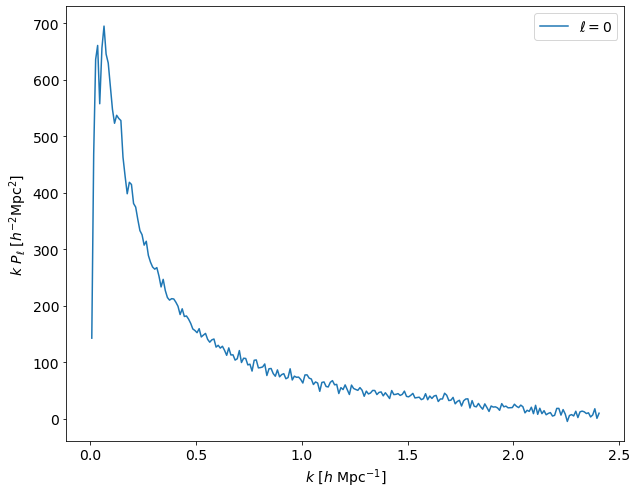

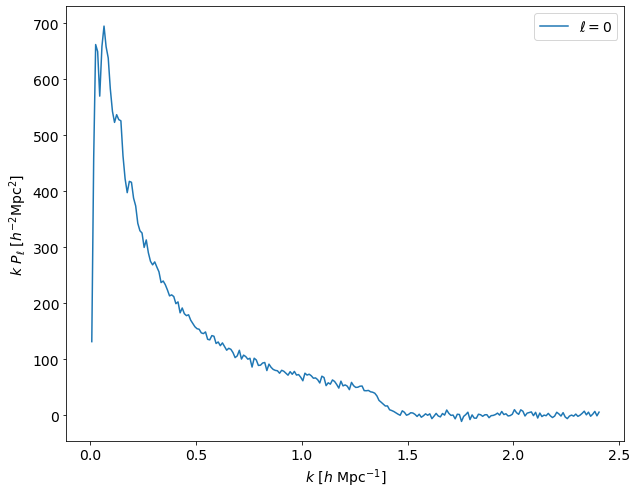

In [23]:
plot_power_spectrum(result.poles)
plot_power_spectrum(result_damped.poles)

In [24]:
result_damped.poles.shotnoise

2025.582584021343

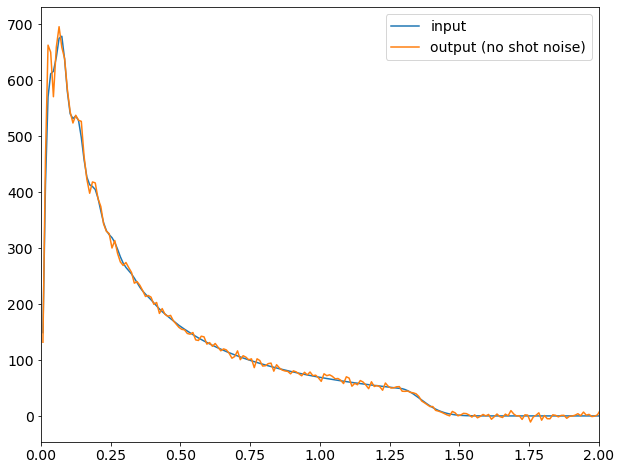

In [28]:
poles = result_damped.poles
plt.plot(poles.k, bias**2 * poles.k*pkdamped(poles.k), label='input')
plt.plot(poles.k, poles.k * poles(ell=0, complex=False, remove_shotnoise=True), label='output (no shot noise)')
#plt.plot(poles.k, poles.k * poles(ell=0, complex=False, remove_shotnoise=False), label='output (with shot noise)')
plt.xlim((0, 2))
plt.legend()

(0.0, 2.0)

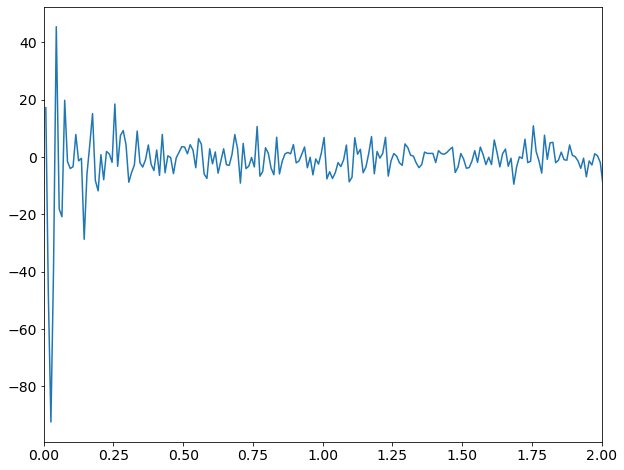

In [30]:
poles = result_damped.poles
plt.plot(poles.k, poles.k*(bias**2 * pkdamped(poles.k)-poles(ell=0, complex=False, remove_shotnoise=True)))
plt.xlim((0, 2))

In [32]:
mock = catalog_data.Data.load(output_dir+'mocks_rsd/AbacusSummit_1Gpc_z1.175_gaussianMock0_truncatedPk_nbarx5.npy')

In [33]:
mock.weights

array([-1.40766065,  0.64592074,  5.7745974 , ...,  1.0508765 ,
        5.55526871,  2.09298021])

In [61]:
from pypower import CatalogMesh
rfield = CatalogMesh(data_positions=mock.positions, data_weights=mock.weights,
                     boxsize=mock.boxsize, boxcenter=mock.boxcenter, nmesh=512,
                     resampler='tsc', interlacing=2).to_mesh(field='data', compensate=True)

[012851.40] [0/1] 06-17 15:13  CatalogMesh               INFO     Slab 0 ~ 4194304 / 14674610.
[012853.62] [0/1] 06-17 15:13  CatalogMesh               INFO     Painted 4194304 out of 14674610 objects to mesh.
[012853.62] [0/1] 06-17 15:13  CatalogMesh               INFO     Slab 4194304 ~ 8388608 / 14674610.
[012855.77] [0/1] 06-17 15:13  CatalogMesh               INFO     Painted 8388608 out of 14674610 objects to mesh.
[012855.77] [0/1] 06-17 15:13  CatalogMesh               INFO     Slab 8388608 ~ 12582912 / 14674610.
[012857.93] [0/1] 06-17 15:13  CatalogMesh               INFO     Painted 12582912 out of 14674610 objects to mesh.
[012857.93] [0/1] 06-17 15:13  CatalogMesh               INFO     Slab 12582912 ~ 16777216 / 14674610.
[012859.06] [0/1] 06-17 15:13  CatalogMesh               INFO     Painted 14674610 out of 14674610 objects to mesh.
[012859.06] [0/1] 06-17 15:13  CatalogMesh               INFO     Running interlacing at order 2.
[012860.66] [0/1] 06-17 15:13  CatalogM

In [62]:
rfield[...] = rfield[...] / rfield.cmean() - 1.
cfield = rfield.r2c()
cfield[...] = cfield[...] * cfield[...].conj()  # P(k)
xifield = cfield.c2r()  # Xi(s)

In [65]:
from pypower.fft_power import project_to_basis
s, mu, xi = project_to_basis(xifield, edges=(np.linspace(0., 200., 51), np.array([-1., 1.])), exclude_zero=True)[0][:3]
s, xi = s.ravel(), xi.ravel()

[012949.68] [0/1] 06-17 15:14  matplotlib.legend         WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


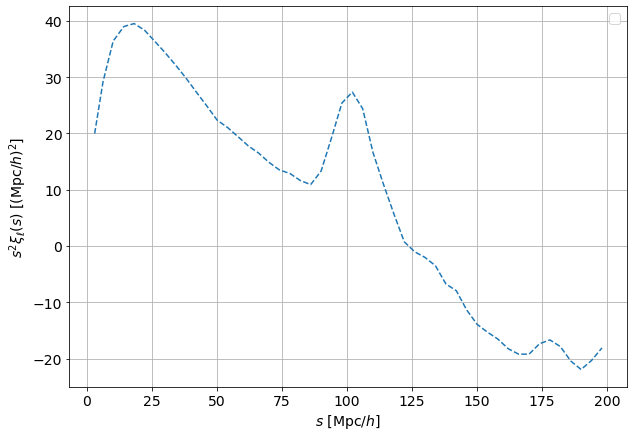

In [66]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(s, s**2 * xi, linestyle = '--')
plt.grid(True)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.legend()
plt.show()